In [2]:
""" Veri Seti Yükleme ve Grafiklerin Ayarları"""
import polars as pl
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Görsel ayarlar - Seaborn ve Matplotlib için daha büyük ve daha net grafikler
plt.rcParams['figure.figsize'] = (16, 5)
plt.rcParams['figure.dpi'] = 100
sns.set_theme(style='darkgrid')

# Veri yükle
LABELED_DATA_PATH = Path("../data/processed/metropt3_labeled.parquet")
df = pl.read_parquet(LABELED_DATA_PATH)

print(f"Veri yüklendi: {df.shape[0]:,} satır, {df.shape[1]} sütun")

Matplotlib is building the font cache; this may take a moment.


Veri yüklendi: 1,516,948 satır, 19 sütun


In [4]:
# Saatlik ortalamayla downsample — 1.5M satır → ~5000 satır
df_hourly = (
    df.with_columns(
        pl.col('timestamp').dt.truncate('1h').alias('hour')     # zamandaki küsüratları atarak saatlik gruplama için yeni bir direkt saat sütun oluşturuyoruz
    )
    .group_by('hour')   # sadece saat sütununa göre gruplama yapıyoruz
    .agg([      # sensörlerin ortalamasını alıyoruz
        pl.col('TP2').mean(),
        pl.col('TP3').mean(),
        pl.col('Oil_temperature').mean(),
        pl.col('Motor_current').mean(),
        pl.col('is_suspect').max()  # Herhangi bir saat diliminde şüpheli bir tane sensör varsa bile o saati şüpheli olarak işaretle
    ])
    .sort('hour')   # saatlere göre sıralama yaparak zaman serisi analizine uygun hale getiriyoruz
)

print(f"Downsample sonrası: {df_hourly.shape[0]:,} satır")
print(df_hourly.head(5))

Downsample sonrası: 4,416 satır
shape: (5, 6)
┌─────────────────────┬──────────┬──────────┬─────────────────┬───────────────┬────────────┐
│ hour                ┆ TP2      ┆ TP3      ┆ Oil_temperature ┆ Motor_current ┆ is_suspect │
│ ---                 ┆ ---      ┆ ---      ┆ ---             ┆ ---           ┆ ---        │
│ datetime[μs]        ┆ f32      ┆ f32      ┆ f32             ┆ f32           ┆ i32        │
╞═════════════════════╪══════════╪══════════╪═════════════════╪═══════════════╪════════════╡
│ 2020-02-01 00:00:00 ┆ 0.502011 ┆ 8.881566 ┆ 51.893749       ┆ 0.89737       ┆ 0          │
│ 2020-02-01 01:00:00 ┆ 0.241003 ┆ 8.984066 ┆ 51.912395       ┆ 1.009373      ┆ 0          │
│ 2020-02-01 02:00:00 ┆ 0.485587 ┆ 9.014171 ┆ 51.719009       ┆ 1.281343      ┆ 0          │
│ 2020-02-01 03:00:00 ┆ 0.492347 ┆ 8.98157  ┆ 51.396763       ┆ 1.286625      ┆ 0          │
│ 2020-02-01 04:00:00 ┆ 0.508242 ┆ 8.996972 ┆ 52.172802       ┆ 1.265721      ┆ 0          │
└─────────────────────┴─

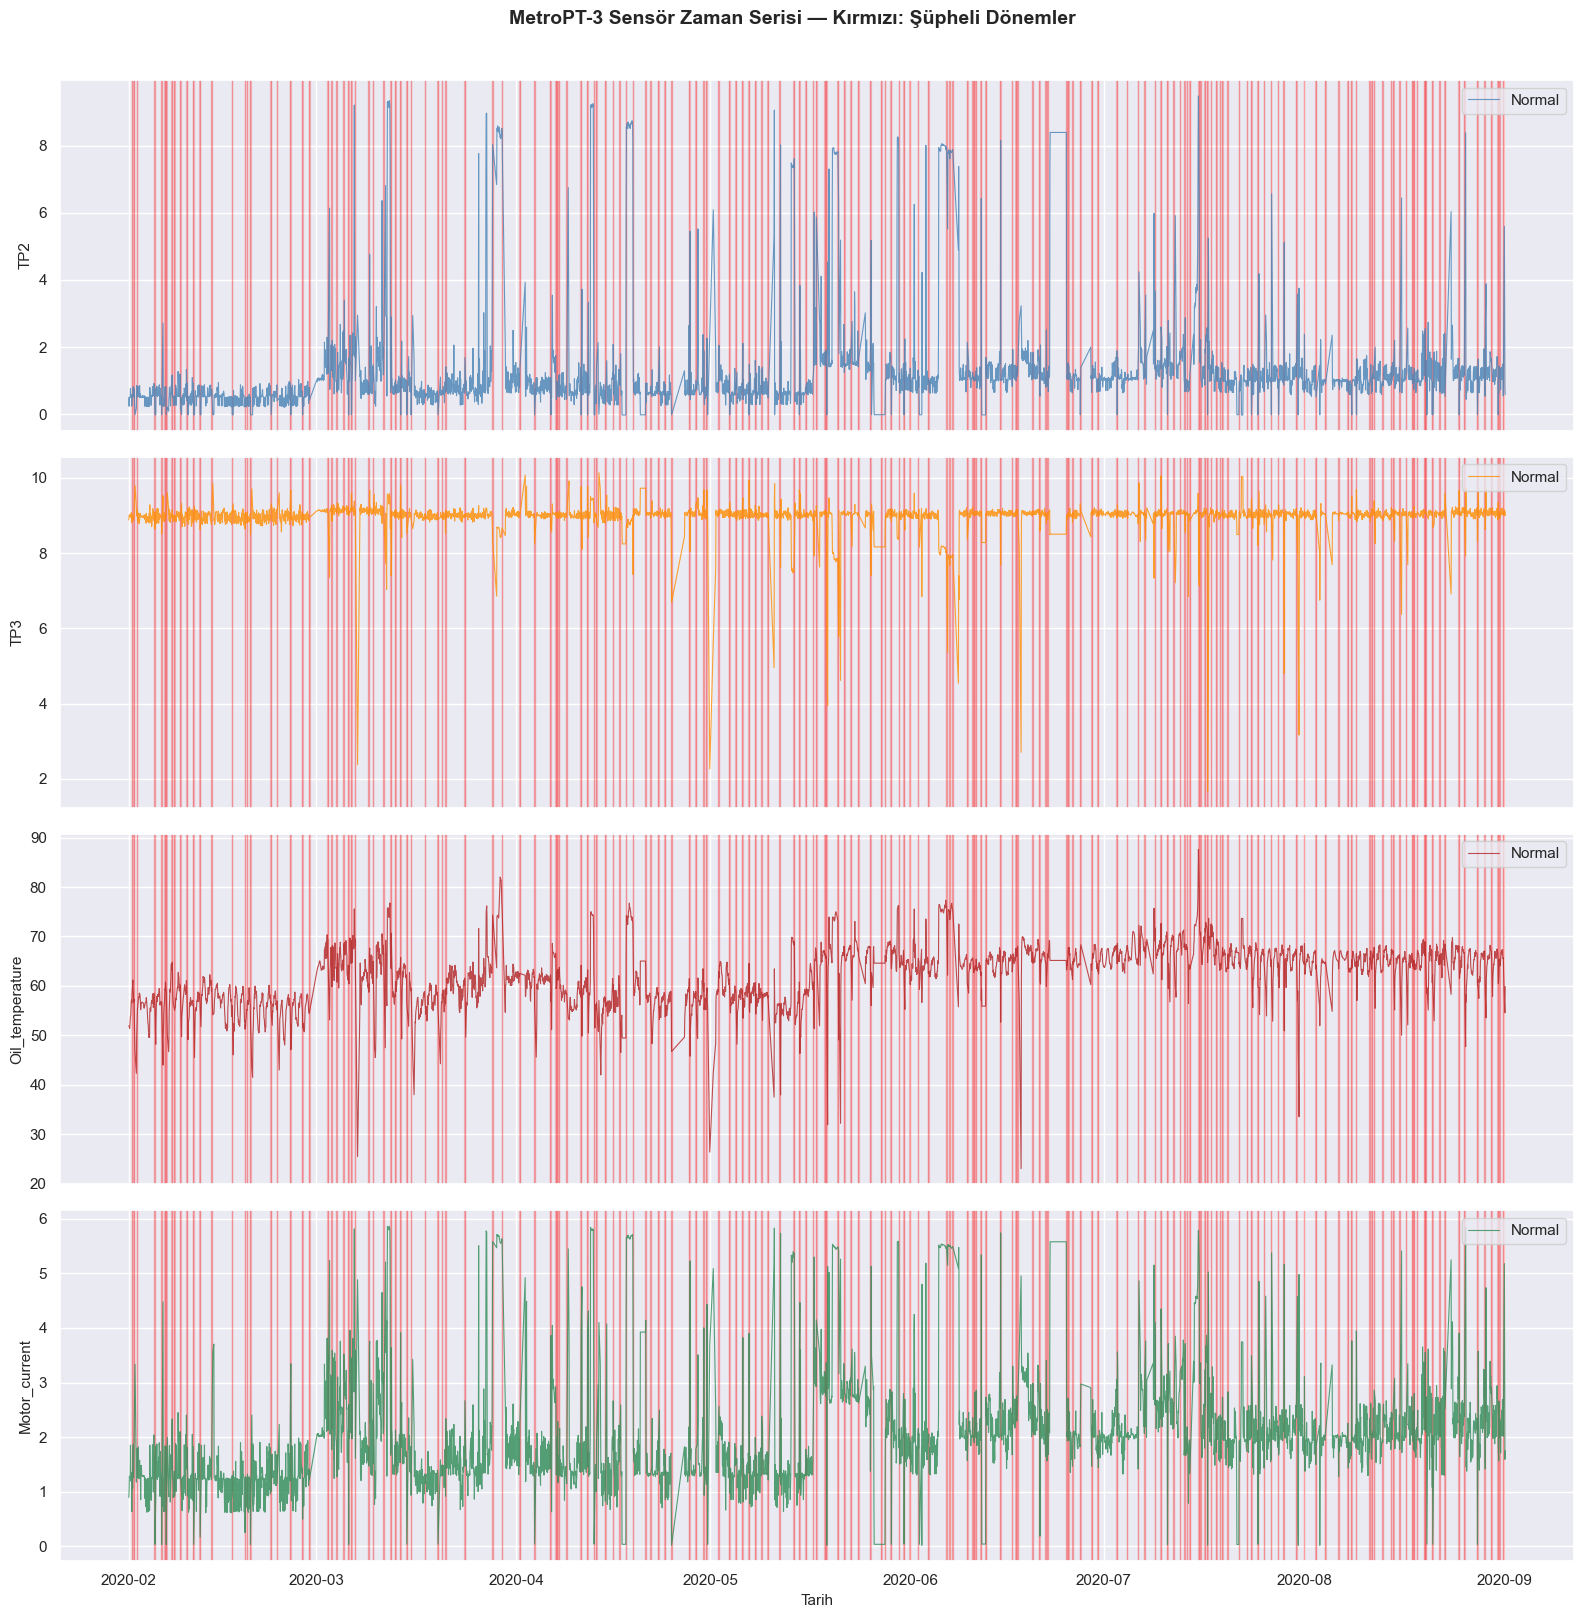

Grafik kaydedildi ✓


In [5]:
# Pandas'a çevir — matplotlib için gerekli
df_plot = df_hourly.to_pandas()

# Şüpheli dönemleri ayır
suspect_hours = df_plot[df_plot['is_suspect'] == 1]

# 4 sensörü ayrı ayrı çiz
fig, axes = plt.subplots(4, 1, figsize=(16, 16), sharex=True)

sensors = ['TP2', 'TP3', 'Oil_temperature', 'Motor_current']
colors = ['steelblue', 'darkorange', 'firebrick', 'seagreen']

for ax, sensor, color in zip(axes, sensors, colors):
    # Normal dönem
    ax.plot(df_plot['hour'], df_plot[sensor], 
            color=color, linewidth=0.8, alpha=0.8, label='Normal')
    
    # Şüpheli dönemleri kırmızı arka planla vurgula
    for _, row in suspect_hours.iterrows():
        ax.axvspan(row['hour'], row['hour'] + pd.Timedelta(hours=1),
                   alpha=0.15, color='red')
    
    ax.set_ylabel(sensor, fontsize=11)
    ax.legend(loc='upper right')

axes[-1].set_xlabel('Tarih', fontsize=11)
fig.suptitle('MetroPT-3 Sensör Zaman Serisi — Kırmızı: Şüpheli Dönemler', 
             fontsize=14, fontweight='bold', y=1.01)

plt.tight_layout()
plt.savefig('../reports/figures/01_timeseries_overview.png', 
            bbox_inches='tight', dpi=150)
plt.show()
print("Grafik kaydedildi ✓")

İstatistiksel olarak incelenebilir durumdaydı %8,7 şüpheli oran vardı ancak durumlar birbiri ile çok bitişik olduğundan gürültüyü arttırarak görsel analizi çok zorlaştırmış. 

Burada 2. yolu izleyeceğiz kısa kapanmaların çoğu öğle molası, vardiya değişimi, rutin bakım vb. olabileceğinden Bunların öncesi kısmi şüpheli değildir diyebiliriz. Bundan dolayı doğru analizi ve eğitimi yapabilmek için arıza oladuğu çok daha muhtemel olan uzun kapanmaları baz alıcaz. Uzunluk olarak da 12 saatten uzun oturumların son 2 saatini şüpheli olarak işaretleyerek bu işlemleri yapıcaz.